In [3]:
import pymc as pm
import arviz as az
import pandas as pd

from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as plt3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp

In [4]:
RANDOM_SEED = 10 
rng = np.random.default_rng(RANDOM_SEED)

In [46]:
# For an nxd input array, returns a 2xd array with the first row storing 
# the minimum value of X in each dimension, and likewise with the maximum 
# in the second row. 
def get_bounds(X):
    return np.vstack((np.min(X, axis=0), np.max(X, axis=0)))

# data_bounds: (2,d) array, defaults to `get_bounds(X)`. 
# target_bounds: (2,d) or (2,) array, defaults to [0,1]^d.  
# If `invert` is True, the roles of source and target bounds are reversed. 
def scale(X, source_bounds=None, target_bounds=None, invert=False):
    d = X.shape[1]

    # Construct the source bounds. 
    if source_bounds is None: 
        source_bounds = get_bounds(X)
    
    # Construct the bounds in each dimension defining the hyperrectangle that 
    # the data will be scaled to lie within. 
    if target_bounds is None:
        target_bounds = np.tile(np.array([0,1]).reshape((2,1)), [1,d])
    elif target_bounds.shape == (2,):
        target_bounds = np.tile(target_bounds.reshape((2,1)), [1,d])
    else:
        assert target_bounds.shape == (2,d)

    if invert: 
        source_bounds,target_bounds = target_bounds,source_bounds
        
    # Linearly map data from source bounds to target bounds. 
    return target_bounds[0,:] + np.multiply(X - source_bounds[0,:], 
                                           (target_bounds[1,:]-target_bounds[0,:]) / (source_bounds[1,:] - source_bounds[0,:])) 




In [66]:
# This function implicitly treats data as lying in the hypercube [-1,1]^d. The output 
# test points can be appropriately scaled to the correct dimensions via the function 
# `scale()` above. 
# Returns an array `X_test` of shape (d, N_points, d), where `X_test[j,:,:]` gives 
# the `N_points` test inputs spread along the jth standard basis vector. 
def gen_extrapolation_test_inputs(d, N_points, max_scaler=2.0, scale="linear"):

    # These scalers are wrt the hypercube [-1,1]^d. 
    if scale=="linear":
        scalers = np.linspace(start= -max_scaler, stop=max_scaler, num=N_points)
    elif scale=="log": 
        raise NotImplementedError 

    X_test = np.empty((d, N_points, d))
    for j in range(d):
        basis_vec = np.zeros(d)
        basis_vec[j] = 1.0
        X_test[j,:,:] = (np.tile(basis_vec.reshape((d,1)), [1,N_points]) * scalers).T

    return X_test

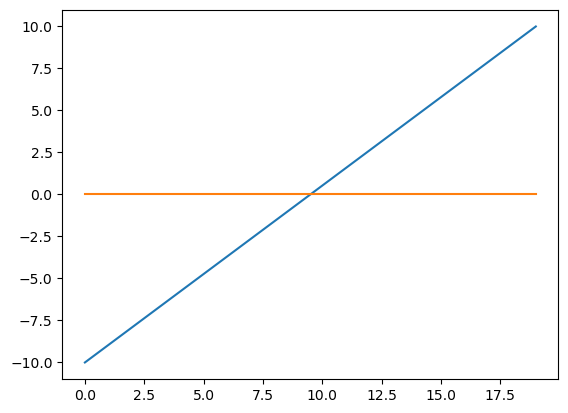

In [69]:
test = gen_extrapolation_test_inputs(2, 20, max_scaler=10.0, scale="linear")

plt.plot(test[0,:,:])
plt.show()

## True Function: Log Gaussian Density

In [7]:
# Define the target function. 

m = np.array([0, 0])
C = np.array([[1, .7], [.7, 1]])
mvn = sp.stats.multivariate_normal(mean=m, cov=C)
f = lambda x : mvn.logpdf(x)
dim_input = 2

In [8]:
# Define grid for plotting and testing. 
n_grid_1d = 50
bound = 2.5
x1_grid = np.linspace(-bound, bound, num=n_grid_1d)
x2_grid = np.linspace(-bound, bound, num=n_grid_1d)
x_grid = np.meshgrid(x1_grid, x2_grid)
# grid_locs = np.dstack(x_grid)
X = np.array([(x1, x2) for x1 in x1_grid for x2 in x2_grid])
y = f(X)
n_grid = X.shape[1]

In [37]:
# Define points spread out along each coordinate axis to test GP behavior as ||x|| -> inf. 
N_test_extrap = 100
X_extrap = np.empty((dim_input, dim_input, N_test_extrap))
mult_scale_max = 20

for d in range(dim_input):
    basis_vec = np.zeros(dim_input)
    basis_vec[d] = 1.0
    

1
2


In [5]:
# Generate design points based on a prior distribution. 
n_design = 8
prior = sp.stats.norm(loc=0.5, scale=0.7)
lh_sampler = sp.stats.qmc.LatinHypercube(d=2)
uniform_design = lh_sampler.random(n=n_design)
X_design = prior.ppf(uniform_design)
y_design = f(X_design)

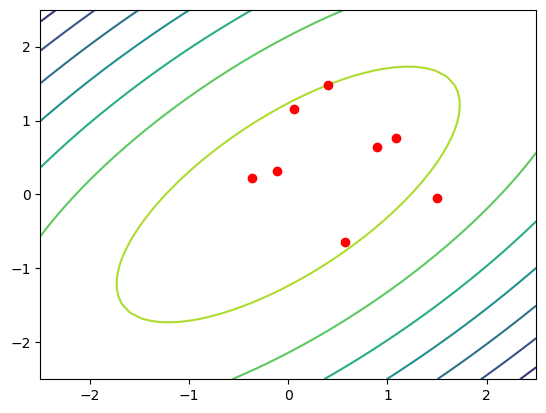

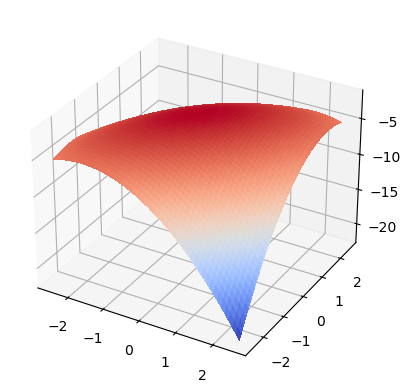

In [6]:
# Contour plot. 
plt.contour(x_grid[0], x_grid[1], y.reshape(n_grid_1d, n_grid_1d))
plt.plot(X_design[:,0], X_design[:,1], "or")
plt.show()

# 3d surface plot. 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=x_grid[0], Y=x_grid[1], Z=y.reshape(n_grid_1d, n_grid_1d), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

## Calculations for Data-Informed GP Hyperparameterization

In [21]:
y_max_idx = np.argmax(y_design)
y_max = np.max(y_design)
X_max = X_design[y_max_idx,:]

y_design_sd = np.std(y_design)

pairwise_dists_X = pairwise_distances(X_design)[np.tril_indices(5, k=-1)]
min_input_dist = np.maximum(np.min(pairwise_dists_X), 1e-06)
max_input_dist = np.max(pairwise_dists_X)

In [23]:
pairwise_dists_y = pairwise_distances(y_design.reshape((n_design,1)))[np.tril_indices(5, k=-1)]

## GP Emulator Models 

### Constant Mean, Quadratic Kernel 

In [27]:
## Constant Mean, Quadratic Kernel
with pm.Model() as gpModel1:    
    # Covariance. 
    sd = 0.5 * max_input_dist
    quad_shift = pm.MvNormal("shift", mu=X_max, cov=sd**2 * np.eye(2))
    offset_cst1 = pm.Uniform("offset", lower=0, upper=np.percentile(pairwise_dists_y, 10))
    cov_func1 = pm.gp.cov.Polynomial(2, c=quad_shift, d=2, offset=offset_cst1)

    # Mean function.
    mean_cst1 = y_max
    mean_func1 = pm.gp.mean.Constant(c=mean_cst1)

    # Specify the GP.
    gp1 = pm.gp.Marginal(mean_func=mean_func1, cov_func=cov_func1)

    # Noiseless GP.  
    y1_ = gp1.marginal_likelihood("Y", X=X_design, y=y_design, sigma=0)

## Fit GP hyperparameters

In [28]:
# Note on variable transformations during optimization: 
# https://stackoverflow.com/questions/42146962/what-does-the-find-map-output-mean-in-pymc3

with gpModel1:
    hyperpar_estimates1 = pm.find_MAP()

print(hyperpar_estimates1)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'shift': array([0.50118047, 0.50364825]), 'offset_interval__': array(-1.55230363), 'offset': array(0.02311771)}


## GP Predictions

In [30]:
with gpModel1: 
    pred1 = gp1.predict(Xnew=X, point=hyperpar_estimates1, diag=True)

## Investigate GP Predictions

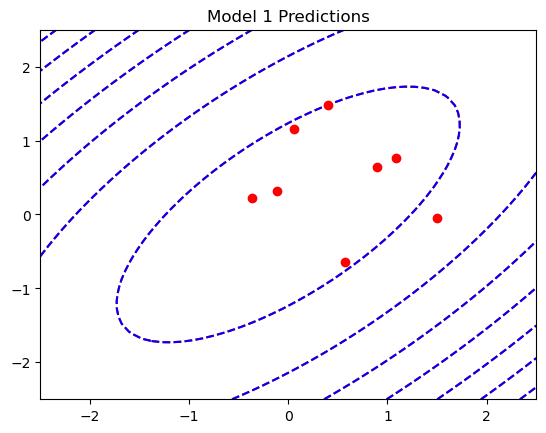

In [31]:
# Model 1
pred_mean1 = pred1[0]
pred_sd1 = np.sqrt(np.maximum(pred1[1], 0))

# Prediction contour plot. 
plt.contour(x_grid[0], x_grid[1], y.reshape(n_grid_1d, n_grid_1d), colors="red")
plt.contour(x_grid[0], x_grid[1], pred_mean1.reshape(n_grid_1d, n_grid_1d), colors="blue")
plt.plot(X_design[:,0], X_design[:,1], "or")
plt.title("Model 1 Predictions")
plt.show()

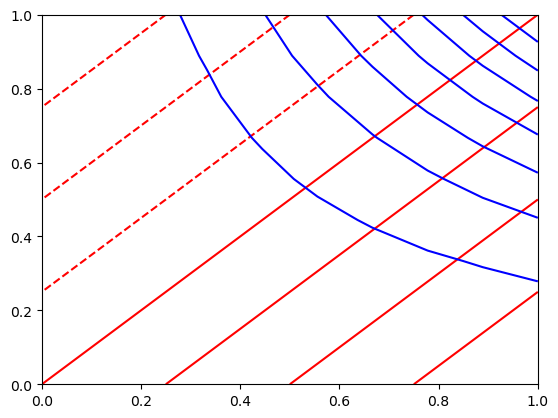

In [32]:
Xt = np.linspace(0, 1, 10)
Yt = np.linspace(0, 1, 10)

xt,yt = np.meshgrid(Xt,Yt)

f1 = np.cos(xt*yt)
f2 = xt-yt

plt.contour(xt,yt,f2,colors='red')
plt.contour(xt,yt,f1,colors='blue')
plt.show()